# Multi-Vehicle Detection and Tracking

For this project, the aim is to take input video frames and detect and track the vehicles in the frames. There are totally 80,000 representative frames across train and test sets as well as 14 different attributes to enhance our predictions. There are totally 50 sequences that have number of frames ranging from 83 to 2790. The videos are captured by an UAV platform at various urban locations such as squares, arterial streets, toll stations, highways, crossings and T-junctions. The videos sequences are recorded at 30 frames per seconds (fps) with the resolution of 1080x540 pixels.

# Sequence-Level Data Attributes and Data Splits

<img src="attrs.png">

<img src="data_types.png">

In [1]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from mrcnn.utils import Dataset, compute_ap
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import product
import joblib

Using TensorFlow backend.


In [2]:
# Keep track of train and test sequences
attr_dir = 'm_attributes/M_attr'
train_seq = [x[1:5] for x in os.listdir(attr_dir+'/train')]
test_seq = [x[1:5] for x in os.listdir(attr_dir+'/test')]

# Sequence Level Features Analysis

In [3]:
# Analyze sequence level attributes in train and test data

def get_seq_attr(train_or_test, seq_dict):
    dir_req = attr_dir+'/'+train_or_test
    for i in os.listdir(dir_req):
        temp = open(dir_req+'/'+i).read().split(',')
        temp = [x[0] for x in temp]
        seq_dict['daylight'].append(temp[0])
        seq_dict['night'].append(temp[1])
        seq_dict['fog'].append(temp[2])
        seq_dict['low_alt'].append(temp[3])
        seq_dict['med_alt'].append(temp[4])
        seq_dict['high_alt'].append(temp[5])
        seq_dict['front_view'].append(temp[6])
        seq_dict['side_view'].append(temp[7])
        seq_dict['bird_view'].append(temp[8])
        seq_dict['long_term'].append(temp[9])
    return seq_dict

train_seq_dict = {'daylight':[],
                 'night':[],
                 'fog':[],
                 'low_alt':[],
                 'med_alt':[],
                 'high_alt':[],
                 'front_view':[],
                 'side_view':[],
                 'bird_view':[],
                 'long_term':[]}

test_seq_dict = {'daylight':[],
                 'night':[],
                 'fog':[],
                 'low_alt':[],
                 'med_alt':[],
                 'high_alt':[],
                 'front_view':[],
                 'side_view':[],
                 'bird_view':[],
                 'long_term':[]}

train_seq_dict = get_seq_attr('train',train_seq_dict)
test_seq_dict = get_seq_attr('test',test_seq_dict)

daylight


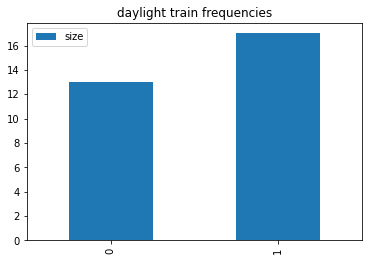

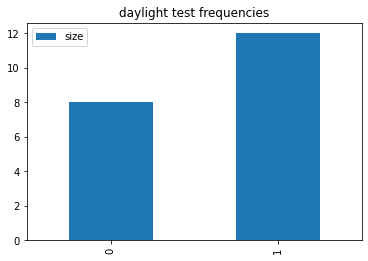



night


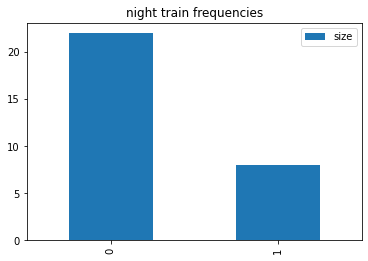

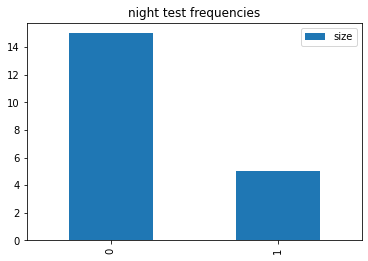



fog


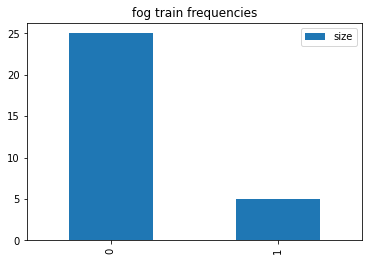

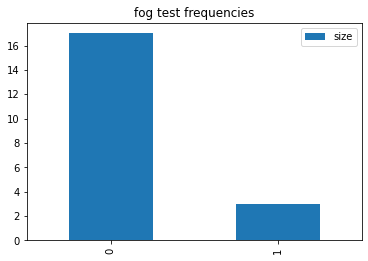



low_alt


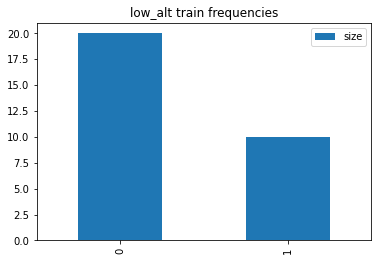

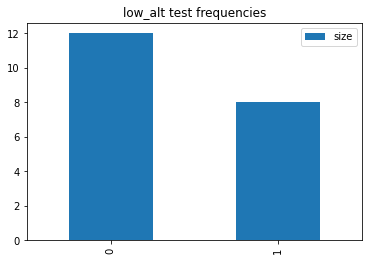



med_alt


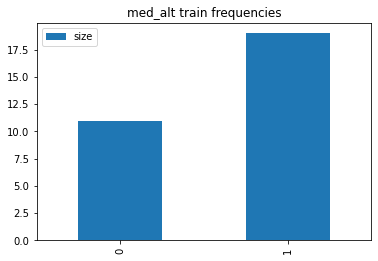

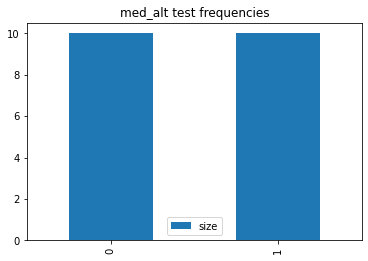



high_alt


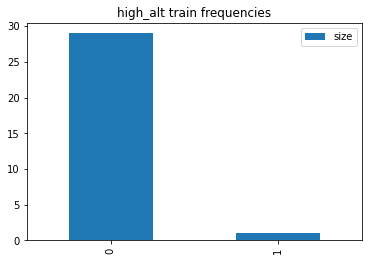

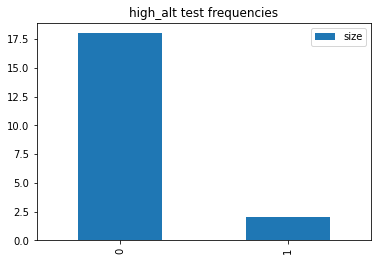



front_view


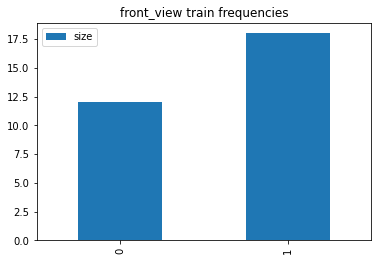

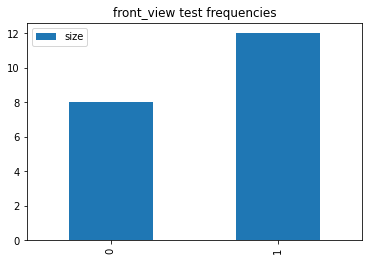



side_view


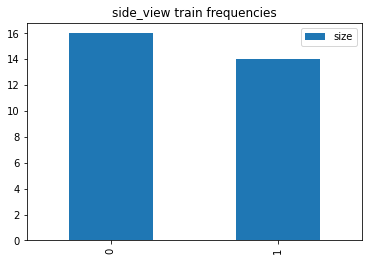

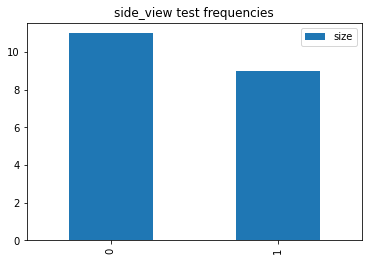



bird_view


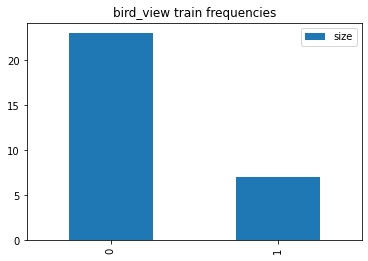

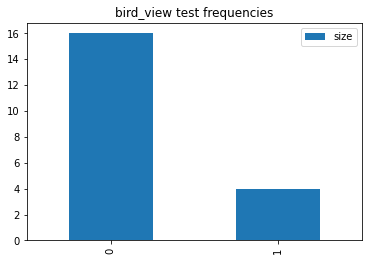



long_term


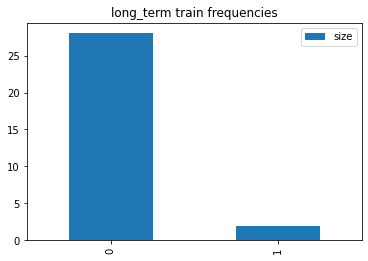

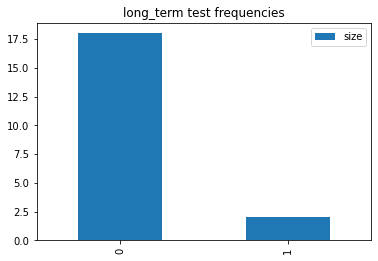

In [4]:
for feature in train_seq_dict:
    print(feature)
    train_list = train_seq_dict[feature]
    test_list = test_seq_dict[feature]
    df = pd.DataFrame({'freq': train_list})
    df.groupby('freq', as_index=False).size().plot(kind='bar')
    plt.title(feature + ' train frequencies')
    plt.show()
    df = pd.DataFrame({'freq': test_list})
    df.groupby('freq', as_index=False).size().plot(kind='bar')
    plt.title(feature + ' test frequencies')
    plt.show()
    print('\n')

# Vehicle Detection Features Analysis

In [4]:
# Create target dataframes for train and test sequences

train_targets = pd.DataFrame()
for t in train_seq:
    target_file = 'm_targets/m_targets/GT/M'+t+'_gt_whole.txt'
    df = pd.read_csv(target_file, header = None)
    df.columns = ['frame_index', 'target_id', 'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height',
                 'out_of_view', 'occlusion', 'object_category']
    df['seq_label'] = t
    train_targets = train_targets.append(df)

test_targets = pd.DataFrame()
for t in test_seq:
    target_file = 'm_targets/m_targets/GT/M'+t+'_gt_whole.txt'
    df = pd.read_csv(target_file, header = None)
    df.columns = ['frame_index', 'target_id', 'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height',
                 'out_of_view', 'occlusion', 'object_category']
    df['seq_label'] = t
    test_targets = test_targets.append(df)

In [5]:
print('Dimensions of train targets from 30 sequences: ',train_targets.shape)
print('Dimensions of test targets from 20 sequences: ',test_targets.shape)

Dimensions of train targets from 30 sequences:  (422911, 10)
Dimensions of test targets from 20 sequences:  (375884, 10)


In [6]:
# Check if any nulls in data
print(train_targets.isnull().sum().sum())
print(test_targets.isnull().sum().sum())

0
0


In [7]:
# See what the data looks like
train_targets.head()

,frame_index,target_id,bbox_left,bbox_top,bbox_width,bbox_height,out_of_view,occlusion,object_category,seq_label
0,1,1,141,147,106,45,1,1,3,0101
1,2,1,138,147,106,45,1,1,3,0101
2,3,1,136,148,106,45,1,1,3,0101
3,4,1,134,148,106,45,1,1,3,0101
4,5,1,131,149,106,45,1,1,3,0101


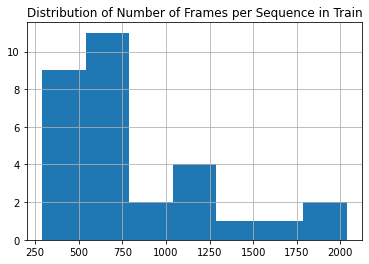

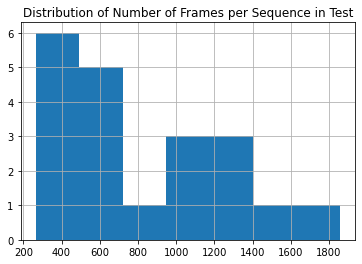

In [9]:
# Check size of sequences in train and test
train_targets.groupby('seq_label')['frame_index'].nunique().hist(bins = 7)
plt.title('Distribution of Number of Frames per Sequence in Train')
plt.show()

test_targets.groupby('seq_label')['frame_index'].nunique().hist(bins = 7)
plt.title('Distribution of Number of Frames per Sequence in Test')
plt.show()

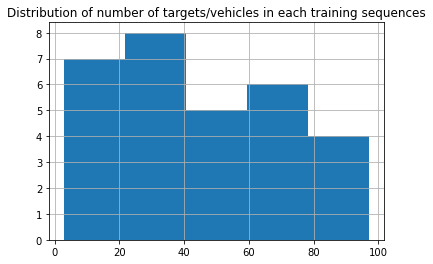

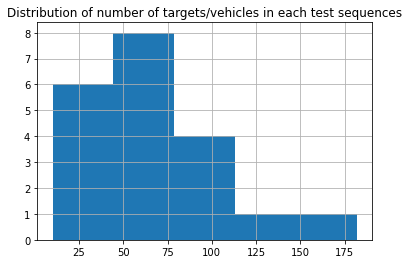

In [10]:
# Get distribution of number of targets per sequence
train_targets.groupby('seq_label')['target_id'].nunique().hist(bins = 5)
plt.title('Distribution of number of targets/vehicles in each training sequences')
plt.show()
print('\n')
test_targets.groupby('seq_label')['target_id'].nunique().hist(bins = 5)
plt.title('Distribution of number of targets/vehicles in each test sequences')
plt.show()

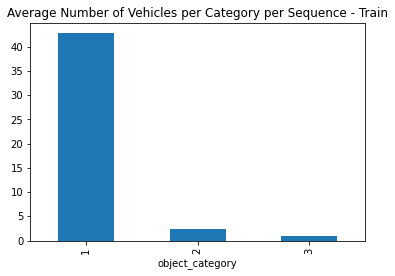

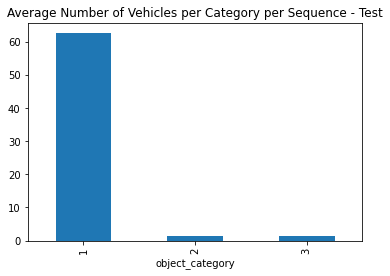

In [11]:
# Number of vehicles belonging to each category 
# 1 = car
# 2 = truck
# 3 = bus

temp = train_targets.groupby(['seq_label', 'object_category'])['target_id'].nunique().reset_index()
temp = pd.DataFrame(list(product(train_targets['seq_label'].unique(), 
                                 train_targets['object_category'].unique())), 
                    columns=['seq_label', 'object_category']).merge(temp, on = ['seq_label', 'object_category'], how = 'outer')
temp.fillna(0, inplace = True)
temp['object_category'] = temp.object_category.astype(str)
temp.groupby('object_category')['target_id'].mean().plot(kind = 'bar')
plt.title('Average Number of Vehicles per Category per Sequence - Train')
plt.show()

temp = test_targets.groupby(['seq_label', 'object_category'])['target_id'].nunique().reset_index()
temp = pd.DataFrame(list(product(test_targets['seq_label'].unique(), 
                                 test_targets['object_category'].unique())), 
                    columns=['seq_label', 'object_category']).merge(temp, on = ['seq_label', 'object_category'], how = 'outer')
temp.fillna(0, inplace = True)
temp['object_category'] = temp.object_category.astype(str)
temp.groupby('object_category')['target_id'].mean().plot(kind = 'bar')
plt.title('Average Number of Vehicles per Category per Sequence - Test')
plt.show()

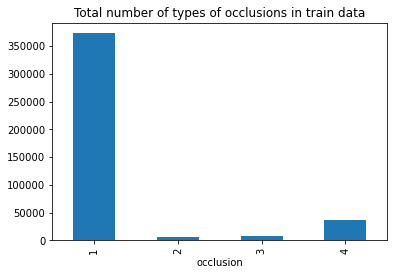

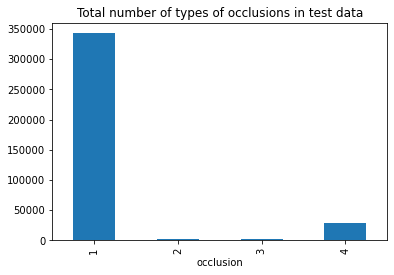

In [12]:
# Number of instances of different types of occlusions in data
# 'no-occ'=1, 'large-occ'=2, 'medium-occ'=3, 'small-occ'=4

train_targets.groupby('occlusion').size().plot(kind = 'bar')
plt.title('Total number of types of occlusions in train data')
plt.show()

test_targets.groupby('occlusion').size().plot(kind = 'bar')
plt.title('Total number of types of occlusions in test data')
plt.show()

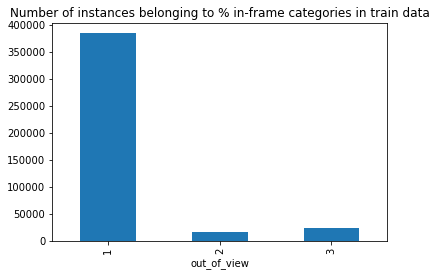

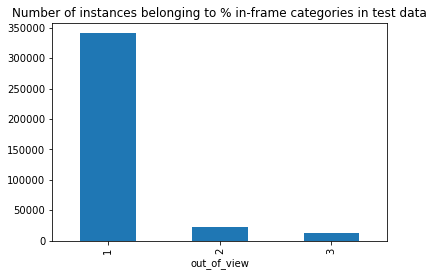

In [13]:
# Number of instances vehicles are in-frame, out-of-frame
# no-out (NO 0%) = 1, small-out (SO 1%~30%) = 3, medium-out (MO 30%~50%) = 2

train_targets.groupby('out_of_view').size().plot(kind = 'bar')
plt.title('Number of instances belonging to % in-frame categories in train data')
plt.show()

test_targets.groupby('out_of_view').size().plot(kind = 'bar')
plt.title('Number of instances belonging to % in-frame categories in test data')
plt.show()

# Object Detection using Mask R-CNN

<img src="arch.png">

In [5]:
# Get the masks for input image in a sequence (train and test)
def get_mask(sequence, image_index):
    
    # Load Image
    img_path = 'm_data/UAV-benchmark-M/M' + sequence + '/img' + '0'*(6-len(str(image_index))) + str(image_index) + '.jpg'
    img = cv2.imread(img_path)
    
    # Convert RGB to grayscale
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get annotations
    if sequence in train_seq:
        df = train_targets[(train_targets.seq_label == sequence) & 
                           (train_targets.frame_index == image_index)].reset_index(drop = True)
    else:
        df = test_targets[(test_targets.seq_label == sequence) & 
                          (test_targets.frame_index == image_index)].reset_index(drop = True)
    
    # Get dimensions of image and number of bounding boxes
    h = img.shape[0]
    w = img.shape[1]
    num_bb = df.shape[0]
    res = np.zeros((h, w), dtype=int)
    
    for i in range(num_bb):
        bb_left = df.bbox_left[i]
        bb_top = df.bbox_top[i]
        bb_width = df.bbox_width[i]
        bb_height = df.bbox_height[i]
        res[bb_top:bb_top + bb_height, bb_left:bb_left + bb_width] = 1
        
    return img, res

In [6]:
img, res = get_mask('0101',1)

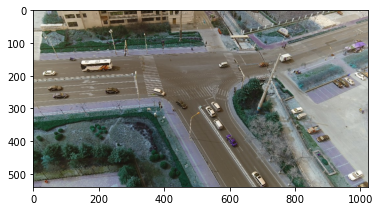

In [7]:
plt.imshow(img)

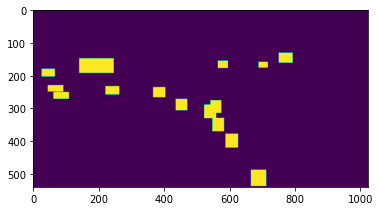

In [8]:
plt.imshow(res)

# Transfer Learning with Mask R-CNN Model built with MS COCO

## First run the existing model in inference mode and test performance on whole data

### To test performance, we predict the bounding boxes and number of vehicles for each image. We compare the difference in number of objects detected (actual vs. predicted) and then for bounding boxes, we use the predicted masks to get intersection between actual and predicted mask divided by the union of the two masks.

In [9]:
# Define a configuration for the model
class VehicleDetection(Config):

    NAME = "vehicle_detection"
    # Number of classes (background + vehicle), change later to accomodate types of vehicles
    NUM_CLASSES = 80+1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131

# prepare config
config = VehicleDetection()

In [10]:
# define the model
model = MaskRCNN(mode = 'inference', model_dir = './', config = config)

# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name = True)#, exclude = ["mrcnn_class_logits", 
                                                      #             "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers only) - change train and test set
#model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')

In [11]:
img_path = 'm_data/UAV-benchmark-M/M' + '0101' + '/img' + '0'*(6-len(str(1))) + str(1) + '.jpg'
img = cv2.imread(img_path)

In [12]:
results = model.detect([img], verbose=0)

In [13]:
results[0]['rois']

array([[ 206,  918,  238,  975],
       [ 148,  146,  187,  241],
       [  93,  949,  134, 1019],
       [ 380,  867,  406,  909],
       [ 182,   29,  202,   74],
       [  91,  391,  124,  402],
       [ 336,  553,  365,  587],
       [ 157,  568,  177,  599],
       [ 374,  581,  419,  627],
       [ 230,   45,  246,   93],
       [ 295,  787,  325,  830]])

In [14]:
temp_df = train_targets[(train_targets.seq_label == '0101')&(train_targets.frame_index == 1)]
bbox_left = temp_df.bbox_left.tolist()
bbox_top = temp_df.bbox_top.tolist()
bbox_width = temp_df.bbox_width.tolist()
bbox_ht = temp_df.bbox_height.tolist()

res_bb_list = []
for i in range(len(bbox_left)):
    res_bb_list.append([bbox_top[i], bbox_left[i], bbox_top[i] + bbox_ht[i], bbox_width[i] + bbox_left[i]])
np.array(res_bb_list)

array([[147, 141, 192, 247],
       [179,  26, 203,  67],
       [232, 221, 258, 264],
       [235, 367, 266, 405],
       [154, 565, 177, 596],
       [158, 689, 176, 718],
       [130, 751, 161, 794],
       [271, 436, 306, 472],
       [288, 523, 330, 560],
       [275, 542, 314, 576],
       [329, 548, 370, 584],
       [250,  62, 271, 110],
       [229,  45, 249,  93],
       [377, 588, 420, 627],
       [487, 666, 537, 713]])

In [15]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
    # plot the image
    plt.imshow(filename)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes_list:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

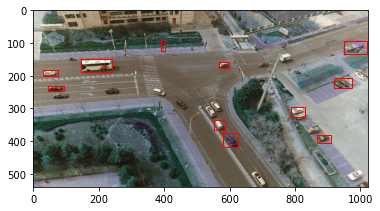

In [16]:
draw_image_with_boxes(img, results[0]['rois'])

In [17]:
# Make predictions for different sequences

def get_preds(train_seq, train_targets, filename):
    predictions_train = pd.DataFrame()

    for t in train_seq:
        img_path = 'm_data/UAV-benchmark-M/M' + t
        images = os.listdir(img_path)
        print(len(images))
        for i in images:
            image_index = int(i[3:9])
            img, mask_actual = get_mask(t,image_index)
            init_model_res = model.detect([img], verbose=0)

            mask_preds = init_model_res[0]['masks'].sum(axis = 2).astype(int)
            iou_perc = (mask_preds * mask_actual > 0).sum()/(mask_preds + mask_actual > 0).sum()
            
            recall = (mask_preds * mask_actual > 0).sum()/(mask_actual > 0).sum()

            act_num_vehicles = train_targets[(train_targets.seq_label == t) & 
                               (train_targets.frame_index == image_index)].shape[0]

            pred_num_objects = len(init_model_res[0]['class_ids'])

            df_temp = pd.DataFrame({'seq':t,
                                   'frame_index':image_index,
                                   'iou_perc':iou_perc,
                                    'recall':recall,
                                   'act_num_vehicles':act_num_vehicles,
                                   'pred_num_objects':pred_num_objects}, index = [0])
            predictions_train = predictions_train.append(df_temp)
        joblib.dump(predictions_train, filename)
        print(t)
    return predictions_train

In [29]:
predictions_test = get_preds(test_seq, test_targets, 'preds_test2.pkl')

646
0205
265
0208
1576
0209
514
0403
372
0601
480
0602
1374
0606
1308
0701
298
0801
1101
0802
1859
1001
269
1004
659
1007
604
1009
864
1101
1182
1301
719


KeyboardInterrupt: 

In [19]:
# Save Images with bounding boxes - example - both actual and predicted
def export_results(seq, train_or_pred, train_targets):
    img_path = 'm_data/UAV-benchmark-M/M' + seq
    images = os.listdir(img_path)
    print(len(images))
    for i in images:
        image_index = int(i[3:9])
        frame_path = 'm_data/UAV-benchmark-M/M' + seq + '/img' + '0'*(6-len(str(image_index))) + str(image_index) + '.jpg'
        img = cv2.imread(frame_path)
        results = model.detect([img], verbose=0)
        
        if train_or_pred == 'pred':
            bbs = results[0]['rois']
        elif train_or_pred == 'train':
            temp_df = train_targets[(train_targets.seq_label == seq)&(train_targets.frame_index == image_index)]
            bbox_left = temp_df.bbox_left.tolist()
            bbox_top = temp_df.bbox_top.tolist()
            bbox_width = temp_df.bbox_width.tolist()
            bbox_ht = temp_df.bbox_height.tolist()

            res_bb_list = []
            for j in range(len(bbox_left)):
                res_bb_list.append([bbox_top[j], bbox_left[j], bbox_top[j] + bbox_ht[j], bbox_width[j] + bbox_left[j]])
            bbs = np.array(res_bb_list)
        
        # plot the image
        plt.imshow(img)
        # get the context for drawing boxes
        ax = plt.gca()
        # plot each box
        for box in bbs:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
        # show the plot
        #plt.show()
        plt.savefig(train_or_pred + '_bb_example/' + seq + '_' + str(image_index) + '.png')
        plt.close()
        print(i)

In [21]:
export_results('0208', 'train', test_targets)
export_results('0208', 'pred', test_targets)

265
img000001.jpg
img000002.jpg
img000003.jpg
img000004.jpg
img000005.jpg
img000006.jpg
img000007.jpg
img000008.jpg
img000009.jpg
img000010.jpg
img000011.jpg
img000012.jpg
img000013.jpg
img000014.jpg
img000015.jpg
img000016.jpg
img000017.jpg
img000018.jpg
img000019.jpg
img000020.jpg
img000021.jpg
img000022.jpg
img000023.jpg
img000024.jpg
img000025.jpg
img000026.jpg
img000027.jpg
img000028.jpg
img000029.jpg
img000030.jpg
img000031.jpg
img000032.jpg
img000033.jpg
img000034.jpg
img000035.jpg
img000036.jpg
img000037.jpg
img000038.jpg
img000039.jpg
img000040.jpg
img000041.jpg
img000042.jpg
img000043.jpg
img000044.jpg
img000045.jpg
img000046.jpg
img000047.jpg
img000048.jpg
img000049.jpg
img000050.jpg
img000051.jpg
img000052.jpg
img000053.jpg
img000054.jpg
img000055.jpg
img000056.jpg
img000057.jpg
img000058.jpg
img000059.jpg
img000060.jpg
img000061.jpg
img000062.jpg
img000063.jpg
img000064.jpg
img000065.jpg
img000066.jpg
img000067.jpg
img000068.jpg
img000069.jpg
img000070.jpg
img000071.jpg
im

# Analysis of Model Performance

In [22]:
preds1 = joblib.load('results_intermediate/preds_test.pkl')
preds2 = joblib.load('results_intermediate/preds_test2.pkl')
preds3 = joblib.load('results_intermediate/preds_train.pkl')

In [30]:
# Convert sequence level attributes to dataframe
train_seq_dict['sequence'] = train_seq
test_seq_dict['sequence'] = test_seq
train_attr_df = pd.DataFrame(train_seq_dict)
test_attr_df = pd.DataFrame(test_seq_dict)
attr_df = train_attr_df.append(test_attr_df)
attr_df = attr_df.rename(columns = {'sequence':'seq'})
attr_df.reset_index(inplace=True)
attr_df

,index,daylight,night,fog,low_alt,med_alt,high_alt,front_view,side_view,bird_view,long_term,seq
0,0,1,0,0,0,1,0,1,1,0,0,0101
1,1,1,0,0,0,1,0,1,0,0,0,0201
2,2,0,1,0,1,0,0,0,1,0,0,0202
3,3,0,1,0,1,0,0,0,1,0,0,0204
4,4,0,1,0,0,1,0,1,1,0,0,0206
5,5,1,0,0,0,1,0,0,1,0,0,0207
6,6,1,0,0,0,1,0,0,0,1,0,0210
7,7,1,0,0,0,1,0,1,0,0,0,0301
8,8,1,0,0,0,1,0,1,0,0,0,0401
9,9,1,0,0,0,1,0,0,1,0,0,0402


In [23]:
preds = preds1.append(preds2).append(preds3)
preds.isnull().sum()

seq                     0
frame_index             0
iou_perc                0
recall              18672
act_num_vehicles        0
pred_num_objects        0
dtype: int64

In [31]:
preds = preds.merge(attr_df, on = 'seq', how = 'left')
preds.isnull().sum()

seq                     0
frame_index             0
iou_perc                0
recall              18672
act_num_vehicles        0
pred_num_objects        0
index                   0
daylight                0
night                   0
fog                     0
low_alt                 0
med_alt                 0
high_alt                0
front_view              0
side_view               0
bird_view               0
long_term               0
dtype: int64

In [35]:
# Get error on number of objects predicted

preds['num_objects_abs_error'] = abs(preds.act_num_vehicles - preds.pred_num_objects)

In [39]:
summary_stats = preds[['iou_perc', 'recall', 'act_num_vehicles', 'pred_num_objects', 'num_objects_abs_error']].describe().T
summary_stats.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
iou_perc,0.117552,0.139462,0.0,0.010832,0.056026,0.187380,0.678375
recall,0.298412,0.307827,0.0,0.060595,0.201991,0.402148,1.000000
act_num_vehicles,19.473031,17.189802,0.0,9.000000,13.000000,24.000000,107.000000
pred_num_objects,7.427175,7.239632,0.0,2.000000,5.000000,11.000000,50.000000
num_objects_abs_error,14.055360,16.916422,0.0,4.000000,8.000000,17.000000,106.000000
